<a href="https://colab.research.google.com/github/yifanwu0909/Yifan-s-Docs/blob/master/Koch_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Author

Yifan Wu  
yw515@georgetown.edu  
2064340079  
linkeIn: https://www.linkedin.com/in/yifan-wu-193050a9/

# Introduction

Predicting stock markets has been an endeavor a lot of people have chased.  Using Machine Learning (ML) and past price data to predict the next periods price or direction in the stock market is not new, neither does it produce any meaningful predictions. Since stock price is a stochastis(non-stationary) process, the characteristics of price movement don’t stay the same with time. Hence, predicting future prices based on historical patterns isn't theoretically possible.


I propose a simple yet effective classification problem where only the direction of the stock is predicted for the next day. That seems much more doable than predicting price. 


# Methodology

The company I chose is Exxon.
XGboost binary classification model is trained with historic Exxon stock index data.

# Result

The model prediction reached 98% accuracy on test data and outperformed S&P500 stock index(67% accuracy).


# Python Implementation

## Import necessary packages


In [1]:
import os
file_dir = "/content/drive/MyDrive/Colab Notebooks/"
os.chdir(file_dir)
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import skopt
from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBClassifier
import pandas_datareader as pdr
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh import extract_features
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve
import xgboost as xgb
import time
import warnings
%matplotlib inline

ERROR:numba.cuda.cudadrv.driver:Call to cuInit results in CUDA_ERROR_NO_DEVICE


In [ ]:
pip install scikit-optimize

In [ ]:
pip install -U tsfresh

In [ ]:
pip install scikit-plot

In [ ]:
#pip install fix-yahoo-finance==0.1.30
!pip install --upgrade pandas-datareader

## Import data

Data source: [Yahoo finance](https://finance.yahoo.com/quote/Xom?ltr=1)

In [2]:
# Convert Date column to datetime
df=pdr.get_data_yahoo('XOM',start = '2015-02-28', end = '2022-02-28')
df=df.reset_index()
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)
df.head()

,date,high,low,open,close,volume,adj_close
0,2015-03-02,88.519997,87.349998,88.339996,88.040001,13793700.0,61.355690
1,2015-03-03,88.019997,87.129997,87.930000,87.620003,13493800.0,61.063007
2,2015-03-04,87.959999,86.930000,87.959999,87.180000,13467600.0,60.756363
3,2015-03-05,87.190002,86.519997,87.070000,86.739998,12527600.0,60.449726
4,2015-03-06,86.599998,85.320000,86.410004,85.629997,16070500.0,59.676163


Text(0, 0.5, 'USD')

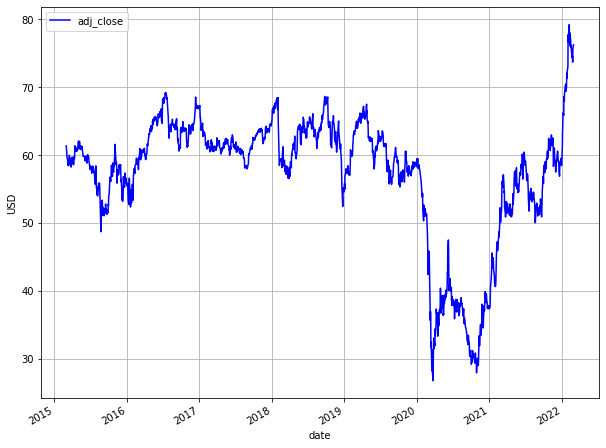

In [3]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

Once the data has been downloaded and stored into a new environment I clean the data up a little, put all the lists into a single data frame, compute the daily returns for each asset and create the up or down direction which will be what the classification model will try to predict. We want to use the adjusted closing prices column to generate direction(adjusted for stock splits, which can make it appear that a stock is performing poorly if a split is included).

In [4]:
df['ret'] = df['adj_close'].pct_change(periods = 1)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df['chng'] = df['ret'].map(lambda v: 1 if v > 0 else 0)
df.head(10)
#a random sample of observations of the data looks like:

,date,high,low,open,close,volume,adj_close,ret,chng
1224,2020-01-10,69.959999,69.120003,69.930000,69.139999,11995600.0,58.016151,-0.008888,0
430,2016-11-11,86.730003,84.889999,86.529999,85.669998,13812200.0,63.455635,-0.015853,0
1438,2020-11-13,36.250000,35.380001,35.400002,36.080002,29241500.0,32.692989,0.024127,1
632,2017-09-01,76.849998,76.320000,76.370003,76.570000,7361100.0,58.334358,0.003144,1
497,2017-02-21,82.150002,81.300003,82.120003,81.889999,16419600.0,61.210453,0.001590,1
504,2017-03-02,84.250000,82.790001,82.800003,83.300003,14170300.0,62.264370,0.003373,1
627,2017-08-25,77.129997,76.430000,76.559998,76.720001,6844900.0,58.448647,0.005109,1
1210,2019-12-19,70.050003,69.239998,69.989998,69.389999,13273200.0,58.225933,-0.006870,0
1674,2021-10-22,63.220001,62.349998,62.770000,63.119999,14266800.0,59.906467,0.006859,1
555,2017-05-15,83.180000,82.650002,83.000000,82.800003,10881500.0,62.475090,0.003028,1


# Feature Engineering

We will generate the following features on a rolling bases: collapse the time series data down by taking the previous N days of data and calculating the feature functions on it. Here I chose N = 7. 

In two of my mail reference project for this project(see foot note), each of them chose a specific set of time series features. Immediately the question popped into my head was: why these features? And is there more features that we can unpack? Through my research I found 10+ features that I can implement but soon I was getting overwhelmed. Lukily I discovered a package call tsfresh, which generate thousands of time series features. It also provide feature selection so we only use the influential ones for training. 

In [5]:
# feature importance https://stackoverflow.com/a/50848452 
from tsfresh import extract_features
# tsfresh:https://towardsdatascience.com/automate-time-series-feature-engineering-in-a-few-lines-of-python-code-f28fe52e4704
df['id'] = 'XOM'
X = df.drop(["chng", "ret", "adj_close"], axis=1)

# Roll time series data with lag number N = 7, we are aggregating information over the pass 7 days, for every day, we calcullate some features using data from day N, N - 1, ... , N - 7
df_rolled = roll_time_series(X, column_id="id", column_sort="date", max_timeshift = 7)
df_features = extract_features(df_rolled, column_id="id", column_sort="date")
skopt.dump(df_features, "df_features.pkl")
df_features.head(3)

Feature Extraction: 100%|██████████| 8810/8810 [08:27<00:00, 17.36it/s]


high__variance_larger_than_standard_deviation  \
XOM 2015-03-03                                            0.0   
    2015-03-04                                            0.0   
    2015-03-05                                            0.0   

                high__has_duplicate_max  high__has_duplicate_min  \
XOM 2015-03-03                      0.0                      0.0   
    2015-03-04                      0.0                      0.0   
    2015-03-05                      0.0                      0.0   

                high__has_duplicate  high__sum_values  high__abs_energy  \
XOM 2015-03-03                  0.0         88.019997       7747.519809   
    2015-03-04                  0.0        175.979996      15484.481248   
    2015-03-05                  0.0        263.169998      23086.577774   

                high__mean_abs_change  high__mean_change  \
XOM 2015-03-03                    NaN                NaN   
    2015-03-04               0.059998          -0.059998   
    2015-03-05               0.414997          -0.414997   

                high__mean_second_derivative_central  high__median  ...  \
XOM 2015-03-03                                   NaN     88.019997  ...   
    2015-03-04                                   NaN     87.989998  ...   
    2015-03-05                                -0.355     87.959999  ...   

                volume__permutation_entropy__dimension_6__tau_1  \
XOM 2015-03-03                                              NaN   
    2015-03-04                                              NaN   
    2015-03-05                                              NaN   

                volume__permutation_entropy__dimension_7__tau_1  \
XOM 2015-03-03                                              NaN   
    2015-03-04                                              NaN   
    2015-03-05                                              NaN   

                volume__query_similarity_count__query_None__threshold_0.0  \
XOM 2015-03-03                                                NaN           
    2015-03-04                                                NaN           
    2015-03-05                                                NaN           

                volume__matrix_profile__feature_"min"__threshold_0.98  \
XOM 2015-03-03                                                NaN       
    2015-03-04                                                NaN       
    2015-03-05                                                NaN       

                volume__matrix_profile__feature_"max"__threshold_0.98  \
XOM 2015-03-03                                                NaN       
    2015-03-04                                                NaN       
    2015-03-05                                                NaN       

                volume__matrix_profile__feature_"mean"__threshold_0.98  \
XOM 2015-03-03                                                NaN        
    2015-03-04                                                NaN        
    2015-03-05                                                NaN        

                volume__matrix_profile__feature_"median"__threshold_0.98  \
XOM 2015-03-03                                                NaN          
    2015-03-04                                                NaN          
    2015-03-05                                                NaN          

                volume__matrix_profile__feature_"25"__threshold_0.98  \
XOM 2015-03-03                                                NaN      
    2015-03-04                                                NaN      
    2015-03-05                                                NaN      

                volume__matrix_profile__feature_"75"__threshold_0.98  \
XOM 2015-03-03                                                NaN      
    2015-03-04                                                NaN      
    2015-03-05                                                NaN      

                volume__me

Almost 4000 features are created from my dataset! Here is the full list: https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html

In [5]:
df_features = skopt.load("df_features.pkl")
df_features = df_features.reset_index(level=[0,1])
df_features = df_features.dropna(axis=1, how='any')
df_features = df_features.rename({'level_0': 'id', 'level_1': 'date'}, axis = 1)

## More features 

Create more time series rolling features manually with a new N. This time I chose N = 3.

* Mean 'adj_close' of each month
* Difference between high and low of each day
* Difference between open and close of each day
* Mean volume of each month

In [6]:
# Get difference between high and low of each day
df['range_hl'] = df['high'] - df['low']

# Get difference between open and close of each day
df['range_oc'] = df['open'] - df['close']

# Add a column 'order_day' to indicate the order of the rows by date
df['order_day'] = [x for x in list(range(len(df)))]

# merging_keys
merging_keys = ['order_day']

# List of columns that we will use to create lags
lag_cols = ['adj_close', 'range_hl', 'range_oc', 'volume']

N = 3  
shift_range = [x+1 for x in range(N)]

for shift in tqdm_notebook(shift_range):
    train_shift = df[merging_keys + lag_cols].copy()
    
    # E.g. order_day of 0 becomes 1, for shift = 1.
    # So when this is merged with order_day of 1 in df, this will represent lag of 1.
    train_shift['order_day'] = train_shift['order_day'] + shift
    
    foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
    train_shift = train_shift.rename(columns=foo)

    df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
del train_shift

  0%|          | 0/3 [00:00<?, ?it/s]

I merge the auto-generated features and manually generated dfeatures together as our feature candicate pool. This is all features that there is that COULD build a accurate model. But I do not know which ones are really informative and which ones are just weakly relavent. Yet!

In [7]:
df_all_features = df.merge(df_features, left_on = "date", right_on = "date")
df_all_features = df_all_features.drop(["chng", "ret", "adj_close"], axis=1)
df_all_features = df_all_features.dropna(axis=1, how='any')

tsfresh have built in feature filtering function. To limit the number of irrelevant features, tsfresh deploys the fresh algorithm (fresh stands for FeatuRe Extraction based on Scalable Hypothesis tests). It is an efficient, scalable feature extraction algorithm, which filters the available features in an early stage of the machine learning pipeline with respect to their significance for the classification or regression task, while controlling the expected percentage of selected but irrelevant features. [(reference)](https://tsfresh.readthedocs.io/en/latest/text/feature_filtering.html)

In [8]:
from tsfresh import extract_features
from tsfresh.feature_selection.relevance import calculate_relevance_table
relevance_table = calculate_relevance_table(df_all_features, df['chng'])
relevance_table = relevance_table[relevance_table.relevant]
relevance_table.sort_values("p_value", inplace=True)
relevance_table = relevance_table.reset_index(drop = True)
relevance_table


,feature,type,p_value,relevant
0,range_oc,real,1.641771e-177,True
1,close__energy_ratio_by_chunks__num_segments_10...,real,1.599245e-82,True
2,close__number_peaks__n_1,real,3.685120e-46,True
3,"close__change_quantiles__f_agg_""mean""__isabs_F...",real,1.308765e-36,True
4,low__energy_ratio_by_chunks__num_segments_10__...,real,7.598428e-36,True
...,...,...,...,...
76,low__time_reversal_asymmetry_statistic__lag_2,real,2.998441e-04,True
77,"open__change_quantiles__f_agg_""mean""__isabs_Fa...",real,3.128749e-04,True
78,"open__change_quantiles__f_agg_""var""__isabs_Tru...",real,3.239422e-04,True
79,close__energy_ratio_by_chunks__num_segments_10...,real,3.280027e-04,True


The above table is the relavent features selected by the filtering algorithm based on their statistical significance. This final 81 features are the ones I am going to train the model on. 

In [11]:
# Organize the feature data
df_rlvt_features = df_all_features[['date'] + relevance_table['feature'].to_list()]
df_merge = df.merge(df_rlvt_features, left_on = "date", right_on = "date")
df_merge = df_merge.dropna(axis=1, how='any')
df_merge['month'] = df_merge['date'].dt.month
df_merge = df_merge.drop(["ret", "adj_close", "id", 'order_day'], axis=1)

# Create training, dev, and test dataset

* Training Dataset: The sample of data used to fit the model.
* Validation Dataset: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. 
* Test Dataset: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.
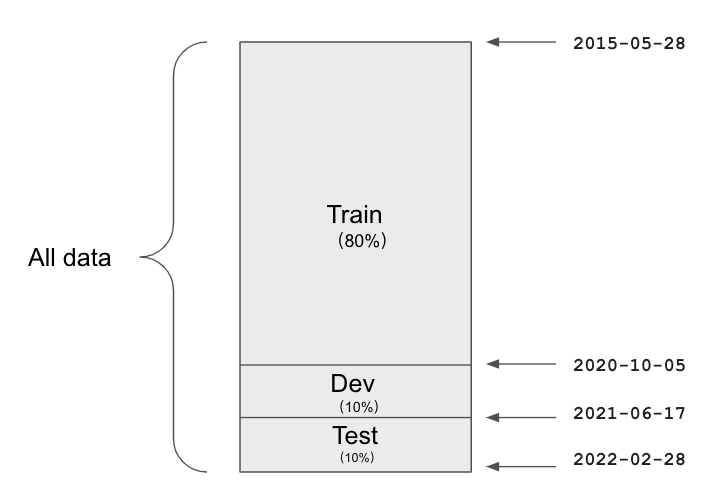


In [12]:
from datetime import datetime
df_merge.sort_values(by='date', inplace=True, ascending=True)

num_cut1 = int(len(df_merge) * 0.8)
num_cut2 = int(len(df_merge) * 0.9)

split_date_1 = df_merge['date'][num_cut1]
split_date_2 = df_merge['date'][num_cut2]

print(str(split_date_1) + '      ' + str(split_date_2)) 
print(str(num_cut1) + '                     ' + str(num_cut2)) 

2020-10-05 00:00:00      2021-06-17 00:00:00
1409                     1585


In [13]:
# Split into train, cv, and test
train = df_merge[:num_cut1]
cv = df_merge[num_cut1:num_cut2]
train_cv = df_merge[:num_cut2]
test = df_merge[num_cut2:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

train.shape = (1409, 91)
cv.shape = (176, 91)
train_cv.shape = (1585, 91)
test.shape = (177, 91)


## Feature scaling

Machine Learning models don't generalize as well on data with high scale variance, so I will adjust the features to a common scale. This process is called Standardizing and will scale data into mean value of 0 and a standard deviation of 1. It's more useful and common for classification tasks.

Example:


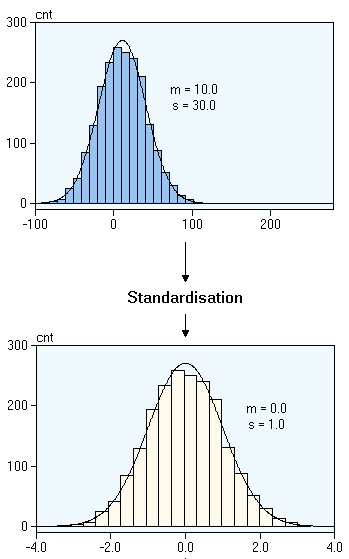


[(reference)](https://www.cnblogs.com/quinn-yann/p/9808247.html)

In [14]:
# Get rid of final target and columns that does not need scaling.
cols_to_scale = list(df_merge.columns)
# items to be removed
no_scale = ['date', 'chng', 'month']
cols_to_scale = [ele for ele in cols_to_scale if ele not in no_scale]

Here we only scale the train dataset, and not the entire dataset to prevent information leak. Data leakage is when information from outside the training dataset is used to create the model. This additional information can allow the model to learn or know something that it otherwise would not know and in turn invalidate the estimated performance of the mode being constructed. Thus we should not standardize the entire dataset. 





In [15]:
# Do scaling for train set
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])
# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)
train_scaled[no_scale] = train.reset_index()[no_scale]
train_scaled.head()

,high,low,open,close,volume,range_hl,range_oc_x,range_oc_y,close__energy_ratio_by_chunks__num_segments_10__segment_focus_7,close__number_peaks__n_1,...,"high__change_quantiles__f_agg_""mean""__isabs_False__qh_1.0__ql_0.6",close__energy_ratio_by_chunks__num_segments_10__segment_focus_6,low__time_reversal_asymmetry_statistic__lag_2,"open__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.0","open__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.2",close__energy_ratio_by_chunks__num_segments_10__segment_focus_0,"high__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.6",date,chng,month
0,0.865029,0.878526,0.898131,0.873213,-0.128971,-0.503104,0.343832,0.343832,-11.719542,-2.16427,...,0.141344,-13.108175,0.063552,0.078673,-0.133575,32.309569,-0.280923,2015-03-03,0,3
1,0.860472,0.863544,0.900397,0.840105,-0.132008,-0.295412,0.919467,0.919467,-11.719542,-2.16427,...,0.141344,-13.108175,0.063552,0.078673,-0.133575,13.900584,-0.280923,2015-03-04,0,3
2,0.801986,0.832831,0.833144,0.806996,-0.240965,-0.829470,0.368332,0.368332,-11.719542,-2.16427,...,0.141344,-13.108175,0.063552,0.078673,-0.133575,7.764672,-0.280923,2015-03-05,0,3
3,0.757171,0.742938,0.783271,0.723473,0.169699,0.075470,0.919477,0.919477,-11.719542,-2.16427,...,0.038421,-13.108175,0.063552,-0.877804,-0.133575,4.732933,-0.280923,2015-03-06,0,3
4,0.740461,0.727956,0.761357,0.688107,-0.011900,0.045793,1.139923,1.139923,-11.719542,-2.16427,...,0.038421,-13.108175,-1.545110,-0.341601,-0.133575,2.904148,-0.280923,2015-03-09,0,3


What is being done here is calculating the parameters for standardizing data within training data itself and use those parameters to standardizing dev set and test set.[(reference)](https://machinelearningmastery.com/data-leakage-machine-learning/)

Now we scale the dev set and test set onto the new distribution of training set.

In [16]:
# Do scaling for dev set
cv_no_scale = cv[no_scale].reset_index()
cv_scaled = scaler.transform(cv[cols_to_scale])
cv_scaled = pd.DataFrame(cv_scaled, columns = [cols_to_scale])
for col in no_scale:
  cv_scaled[col] = cv_no_scale[col]

In [17]:
# Do scaling for test set
test_no_scale = test[no_scale].reset_index()
test_scaled = scaler.transform(test[cols_to_scale])
test_scaled = pd.DataFrame(test_scaled, columns = [cols_to_scale])
for col in no_scale:
  test_scaled[col] = test_no_scale[col]


## Split into X and y

X: features to train on.   
y: target {'0', '1'}, which means stock price go up(1) or down(0).

In [18]:
if "month" not in cols_to_scale:
  cols_to_scale.append("month")
target = "chng"
features = cols_to_scale.copy()
 
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
y_cv_scaled = cv_scaled[target]
X_test_scaled = test_scaled[features]
y_test_scaled = test_scaled[target]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("y_cv_scaled.shape = " + str(y_cv_scaled.shape))
print("X_test_scaled.shape = " + str(X_test_scaled.shape))
print("y_test.shape = " + str(y_test_scaled.shape))

X_train_scaled.shape = (1409, 89)
y_train_scaled.shape = (1409,)
X_cv_scaled.shape = (176, 89)
y_cv_scaled.shape = (176, 1)
X_test_scaled.shape = (177, 89)
y_test.shape = (177, 1)


## Train the model

There are 3 state-of-the-art algorithms when it comes to time series forcasting: ARIMA model, Long Short Term Memory (LSTM) model and Extreme Gradient Boosting (XGBoost) models. 

In [this paper](https://escholarship.org/uc/item/0zp9s76c), all three models produced good forecast of next day’s stock price. But XGBoost can provide feature importance analysis, which aids interpretability, and it requires least time for parameter tuning and forecast calculation. Due to the time-limit and computation power limit, natually I choose to train XGBoost model for stock direction forcasting.


Machine learning models come with default parameters: if you do not assign a specific value or string to an optional parameter, the algorithm does it automatically by a preset value or string. However, optimal parameters may vary from one data set the to other, so default parameters are usually not optimal. One needs to find the optimal parameters by grid search, where the grid represents the experimental values of each parameter (n-dimensional space).

In [144]:
# Create the default model
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier
model = XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)

# Train the classifier
model.fit(X_train_scaled, y_train_scaled)

XGBClassifier(eval_metric='auc', grow_policy='lossguide', tree_method='hist',
              use_label_encoder=False)

In [145]:
#extracting default parameters from benchmark model
default_params = {}
gparams = model.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

#No. of jobs
bcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]
bcvj = int(bcvj)

#unwrapping list values of default parameters
default_params_xgb = {}

for key in default_params.keys():
    default_params_xgb[key] = default_params[key][0]

#providing default parameters to xgbc model, before Bayesian based search cross-validation
xgbc = xgb.XGBClassifier(**default_params_xgb)



Bayesian search — “an extremely powerful technique when the mathematical form of the function is unknown or expensive to compute. The main idea behind it is to compute a posterior distribution over the objective function based on the data (using the famous Bayes theorem), and then select good points to try with respect to this distribution”. [(reference)](https://cloud.google.com/blog/products/ai-machine-learning/hyperparameter-tuning-cloud-machine-learning-engine-using-bayesian-optimization)

In [ ]:
clf = BayesSearchCV(estimator=xgbc, search_spaces=param_grid, n_iter=bcvj, scoring='accuracy', cv=3, return_train_score=True, verbose=3)
clf.fit(X_train_scaled, y_train_scaled.values.ravel())
file_dir = "/content/drive/MyDrive/Colab Notebooks/"
import skopt
skopt.dump(clf, file_dir + "xgboost_stock_price_tuned.pkl")

In [19]:
clf = skopt.load(file_dir + "xgboost_stock_price_tuned.pkl")

In [20]:
#results dataframe
df = pd.DataFrame(clf.cv_results_)

In [21]:
#predictions - inputs to confusion matrix
train_predictions = clf.predict(X_train_scaled)
test_predictions = clf.predict(X_cv_scaled)
unseen_predictions = clf.predict(X_test_scaled)
    
#confusion matrices
cfm_train = confusion_matrix(y_train_scaled, train_predictions)
cfm_test = confusion_matrix(y_cv_scaled, test_predictions)
cfm_unseen = confusion_matrix(y_test_scaled, unseen_predictions)
    
#accuracy scores
accs_train = accuracy_score(y_train_scaled, train_predictions)
accs_test = accuracy_score(y_cv_scaled, test_predictions)
accs_unseen = accuracy_score(y_test_scaled, unseen_predictions)
    
#F1 scores for each train/test label
f1s_train_p1 = f1_score(y_train_scaled, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y_train_scaled, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_cv_scaled, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_cv_scaled, test_predictions, pos_label=0)
f1s_unseen_p1 = f1_score(y_test_scaled, unseen_predictions, pos_label=1)
f1s_unseen_p0 = f1_score(y_test_scaled, unseen_predictions, pos_label=0)
    
#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_cv_scaled, clf.predict_proba(X_cv_scaled)[:,1])
unseen_ras = roc_auc_score(y_test_scaled, clf.predict_proba(X_test_scaled)[:,1])
    
#best parameters
bp = clf.best_params_


#storing computed values in results dictionary
results_dict = {}
results_dict['xgbc_rcv'] = {'classifier': deepcopy(clf),
                            'cv_results': df.copy(),
                            'cfm_train': cfm_train,
                            'cfm_dev': cfm_test,
                            'cfm_test': cfm_unseen,
                            'train_accuracy': accs_train,
                            'dev_accuracy': accs_test,
                            'test_accuracy': accs_unseen,
                            'train F1-score label 1': f1s_train_p1,
                            'train F1-score label 0': f1s_train_p0,
                            'dev F1-score label 1': f1s_test_p1,
                            'dev F1-score label 0': f1s_test_p0,
                            'test F1-score label 1': f1s_unseen_p1,
                            'test F1-score label 0': f1s_unseen_p0,
                            'dev roc auc score': test_ras,
                            'test roc auc score': unseen_ras,
                            'best_params': bp}


# Predict on test set

In [22]:
# Do prediction on train set
pred_train = clf.predict(X_train_scaled)
#Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_train_scaled, pred_train))
print(metrics.confusion_matrix(y_train_scaled, pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       715
           1       1.00      1.00      1.00       694

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409

[[715   0]
 [  0 694]]


In [23]:
# Do prediction on test set
pred_test = clf.predict(X_test_scaled)
#Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test_scaled, pred_test))
print(metrics.confusion_matrix(y_test_scaled, pred_test, labels= list(set(pred_test))))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        84
           1       0.98      0.98      0.98        93

    accuracy                           0.98       177
   macro avg       0.98      0.98      0.98       177
weighted avg       0.98      0.98      0.98       177

[[82  2]
 [ 2 91]]


I am very satisfied with the above result. The model is able to reach to 98% accuracy on unseen data. Let's see how is the S&P500 stock compare to this result.

## Compare to S&P500

Perform the same preprocessing and scaling on the sp500 stock data.

In [24]:
# ^GSPC

sp500=pdr.get_data_yahoo('^GSPC',start = '2015-02-28', end = '2022-02-28')
sp500=sp500.reset_index()
# Convert Date column to datetime
sp500.loc[:, 'Date'] = pd.to_datetime(sp500['Date'],format='%Y-%m-%d')
# Change all column headings to be lower case, and remove spacing
sp500.columns = [str(x).lower().replace(' ', '_') for x in sp500.columns]
# Sort by datetime
sp500.sort_values(by='date', inplace=True, ascending=True)
sp500['ret'] = sp500['adj_close'].pct_change(periods = 1)
sp500.dropna(inplace=True)
sp500.reset_index(drop=True, inplace=True)
sp500['chng'] = sp500['ret'].map(lambda v: 1 if v > 0 else 0)

In [25]:
test_date_only = test[['date']]
sp500.loc[:, 'date'] = pd.to_datetime(sp500['date'],format='%Y-%m-%d')
sp500 = sp500.merge(test_date_only, how='inner', on = 'date')
len(sp500) == len(test_date_only)

True

In [26]:
print(metrics.classification_report(y_test_scaled, sp500['chng']))
print(metrics.confusion_matrix(y_test_scaled, sp500['chng']))

              precision    recall  f1-score   support

           0       0.65      0.62      0.63        84
           1       0.67      0.70      0.68        93

    accuracy                           0.66       177
   macro avg       0.66      0.66      0.66       177
weighted avg       0.66      0.66      0.66       177

[[52 32]
 [28 65]]


In [27]:
# Requery Exxon stock data with adjusted closing price since previous this column is replaced by stock price direction
df = pdr.get_data_yahoo('XOM',start = '2015-02-28', end = '2022-02-28')
df=df.reset_index()
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
df.sort_values(by='date', inplace=True, ascending=True)
test_close_adj = sp500[['date']].merge(df, how = 'inner', on = 'date')
test_scaled_close_adj = scaler.fit_transform(test_close_adj[['adj_close']])
test_scaled_close_adj = pd.DataFrame(test_scaled_close_adj, columns=['adj_close'])
test_scaled_close_adj['date'] = test_close_adj['date']
sp500_scaled = scaler.fit_transform(sp500[['adj_close']])
sp500_scaled = pd.DataFrame(sp500_scaled, columns=['adj_close'])
sp500_scaled['date'] = sp500['date']

Text(0.5, 1.0, 'Both scaled to reveal trend')

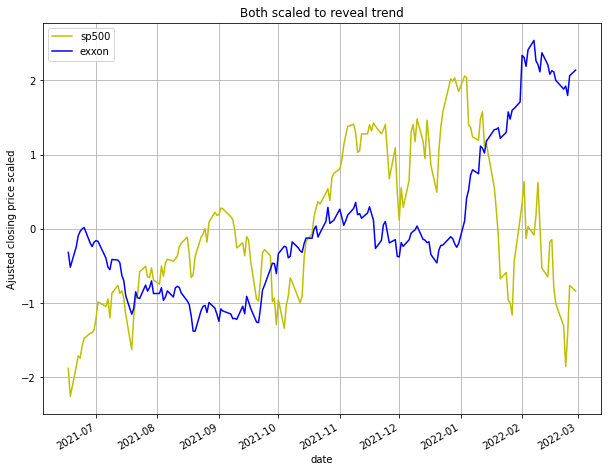

In [28]:
# Plot adjusted close over time for SP500 and Exxon index

rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = sp500_scaled.plot(x='date', y='adj_close', style='y-', grid=True)
ax = test_scaled_close_adj.plot(x='date', y='adj_close', style='b-', grid=True, ax=ax)
ax.legend(['sp500', 'exxon'])
ax.set_xlabel("date")
ax.set_ylabel("Ajusted closing price scaled")
ax.set_title("Both scaled to reveal trend")

The Xgboost yields a very good performance, out ranking SP500. 

# Potential Improvement


* Choose longer time span to extend training data size.   
* Experience with different rolling lag number N.
* Add company fundamental data as new features.
* Incorporate daily sentiment data. give each day a sentiment score. This can be done using tweeter text mining and sentiment analysis. 
* Experiment with different models like LSTM  
...





https://iopscience.iop.org/article/10.1088/1742-6596/2161/1/012065/pdf
sentiment analysis code: https://github.com/rania751/Stock_Market_Prediction_LSTM_Numerical_Textual_Analysis/blob/main/stock-market-prediction-lstm-numerical-textual-ana.ipynb


# Reference

two of my main inspiration projects:
1. https://lf0.com/post/xgboost-time-series-classification-trading-strategy/xgboost-time-series-quant-trading-strategy/
2. https://github.com/nikkizhao1202/Trading_Strategy_SP500/blob/master/XGBoost/XGBoost.ipynb

Other references

https://medium.com/auquan/https-medium-com-auquan-machine-learning-techniques-trading-b7120cee4f05

https://lf0.com/post/xgboost-time-series-classification-trading-strategy/xgboost-time-series-quant-trading-strategy/
https://github.com/nikkizhao1202/Trading_Strategy_SP500/blob/master/XGBoost/XGBoost.ipynb

https://escholarship.org/uc/item/0zp9s76c
